# CBED- Thickness Calculator

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, e, c, m_e
from scipy.stats import linregress
import itertools
from scipy.stats import t


#conda install -c conda-forge ipywidgets
import ipywidgets as widgets
from IPython.display import display

In [6]:
def get_wavelength(acceleration_voltage):
    # https://www.jeol.co.jp/en/words/emterms/search_result.html?keyword=wavelength%20of%20electron
    # https://www.jeol.co.jp/en/words/emterms/search_result.html?keyword=relativistic%20correction
    V_corrected = acceleration_voltage*(1+ (e)/(2*m_e*c**2)*acceleration_voltage)
    lambd = h/np.sqrt(2*m_e*e*V_corrected)
    return lambd

def write_parameter_file(fname, params, overwrite):
    pass

def make_theta_list(t1,t2,t3,t4):
    if t4 !=0.0:
        return [t1,t2,t3,t4]
    else:
        return [t1,t2,t3]
    
def get_d_hkl(hkl, a =0.40475e-9):
    #a taken from https://arxiv.org/ftp/arxiv/papers/2002/2002.01562.pdf
    (h,k,l) = hkl
    d_hkl= a/np.sqrt(h**2+k**2+l**2)
    return d_hkl

def make_si(theta_list, d_kik, d_hkl, wavelength):
    si_list = [(wavelength*theta)/(d_kik*d_hkl**2) for theta in theta_list]
    return np.array(si_list)

def get_thickness_plot(si_list, kStart = 1, kStop = 3):

    d_exct_list = []
    t_error_list = []
    t_list = []
    r2_list = []
    
    #For easy plotting
    x_data = []
    y_data = []
    slope_data = []
    intercept_data = []
    std_yintercept = []
    
    
    for i in range(kStop):
        nk_list = np.arange(start=kStart, stop= len(si_list)+kStart, step=1) #creating the necessary n_k
        SIsquared_over_NKsquared= np.array([S**2/N**2 for (S,N) in zip(si_list,nk_list)]) #creating Yvalues
        ONE_over_NKsquared = np.array([1/N**2 for N in nk_list]) #creating Xvalues
        y_data.append(SIsquared_over_NKsquared)
        x_data.append(ONE_over_NKsquared)
        
        result= linregress(ONE_over_NKsquared, SIsquared_over_NKsquared) #Getting all the necessary Data
        slope_data.append(result.slope)
        intercept_data.append(result.intercept)
        
        
        std_yintercept.append(result.intercept_stderr)
        

        # Getting Extinction length and Thickness T
        d_exct_g = np.sqrt(np.abs(1/result.slope)) * 10**9 # in nm
        d_exct_list.append(d_exct_g)
        
        t = np.sqrt(1/result.intercept)*10**9 # in nm  
        t_list.append(t)
        
        t_error_list.append(np.sqrt(1/result.intercept_stderr)*10**9)
        r2_list.append(result.rvalue**2)
        kStart+=1
        
        
    ##########
    #Determening uncertainty (Christoph apparently called Jackknife method):
    possible_t=[]
    pairs = []
    for m in range(kStop):
        pairs.append([])
        
        for i in zip(x_data[m],y_data[m]):
            pairs[m].append(i)
    all_combinations=[]
    for j in range(len(pairs)):
        combinations = itertools.combinations(pairs[j],len(x_data[m])-1)
        all_combinations.append(combinations)
        
 
    for k in range(len(all_combinations)):
        possible_t.append([])
        for line in list(all_combinations[k]):
            line_x = []
            line_y = []
            for point in line:
                line_x.append(point[0])
                line_y.append(point[1])
            result= linregress(line_x, line_y)
            t = np.sqrt(1/result.intercept)*10**9 # in nm  
            possible_t[k].append(t)
            
    t_std= []
    for l in range(len(possible_t)):
        t_std.append(np.nanstd(possible_t[l]))
        
      

    ############
    #Plotting
    plt.rcParams.update({'font.size': 18})
    
    fig, ax = plt.subplots(1,kStop, figsize = (25,10))
    for i in range(kStop):
        ax[i].plot(x_data[i],intercept_data[i]+slope_data[i]*x_data[i],c='g',label = r'$R^2$: '+str(round(r2_list[i],3))+'\n'+r'$\xi$ [nm]: '+str(round(d_exct_list[i],1))+'\n Thickness [nm]: '+str(round(t_list[i],1))+r'$\pm$'+str(round(t_std[i],1)))
        ax[i].scatter(x_data[i],y_data[i], c= 'r')
    
    
    
    for a in ax:
        a.legend(loc= 'upper right', facecolor='bisque')
        a.set_xlabel(r'$\frac{1}{n_k^2}$')
        y_label= a.set_ylabel(r'$\frac{s_i^2}{n_k^2}$')
        y_label.set_rotation(0)
        a.set_yticklabels([])
        a.set_xticklabels([])
    plt.show()

    

slider = widgets.IntSlider(
    min=80,
    max=300,
    step=20,
    description='Voltage [kV]:',
    value=200,
    orientation = 'horizontal')

latticeParam = widgets.FloatText(
    value=0.40475e-9,
    description='Lattice Parameter [nm]:',
    disabled=False
)

kik_band = widgets.Dropdown(
    options=[(2,0,0), (2,2,0), (2,2,2)],
    value=(2,2,0),
    description='Kikuchi Band:',
    disabled=False,
)
kStop_slider = widgets.IntSlider(
    min=1,
    max=10,
    step=1,
    description='max. iterator',
    value=2,
    orientation = 'horizontal')

fname = widgets.Text(
    placeholder='Parameter Filename',
    description='String:',
    disabled=False
)

overWrite= widgets.ToggleButtons(
    options=['No', 'Yes'],
    description='Overwrite',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

d_kik = widgets.FloatText(
    value=0,
    description='Kikuchi Spacing:',
    disabled=False
)
theta1 = widgets.FloatText(
    value=0,
    description='Theta1:',
    disabled=False
)
theta2 = widgets.FloatText(
    value=0,
    description='Theta2:',
    disabled=False
)
theta3 = widgets.FloatText(
    value=0,
    description='Theta3:',
    disabled=False
)
theta4 = widgets.FloatText(
    value=0.0,
    description='Theta4:',
    disabled=False
)

button = widgets.Button(description='Click Me!')
display(slider, kStop_slider, latticeParam, kik_band,fname,overWrite, d_kik,theta1,theta2,theta3, theta4)    



IntSlider(value=200, description='Voltage [kV]:', max=300, min=80, step=20)

IntSlider(value=2, description='max. iterator', max=10, min=1)

FloatText(value=4.0475e-10, description='Lattice Parameter [nm]:')

Dropdown(description='Kikuchi Band:', index=1, options=((2, 0, 0), (2, 2, 0), (2, 2, 2)), value=(2, 2, 0))

Text(value='', description='String:', placeholder='Parameter Filename')

ToggleButtons(description='Overwrite', options=('No', 'Yes'), value='No')

FloatText(value=0.0, description='Kikuchi Spacing:')

FloatText(value=0.0, description='Theta1:')

FloatText(value=0.0, description='Theta2:')

FloatText(value=0.0, description='Theta3:')

FloatText(value=0.0, description='Theta4:')

## Type in your values above and execute the cell below
If only 3 minima are used, keep Theta4=0!

<ipython-input-6-bd0e4b53fe35>:93: RuntimeWarning: divide by zero encountered in double_scalars
  t = np.sqrt(1/result.intercept)*10**9 # in nm
C:\Users\chhe\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


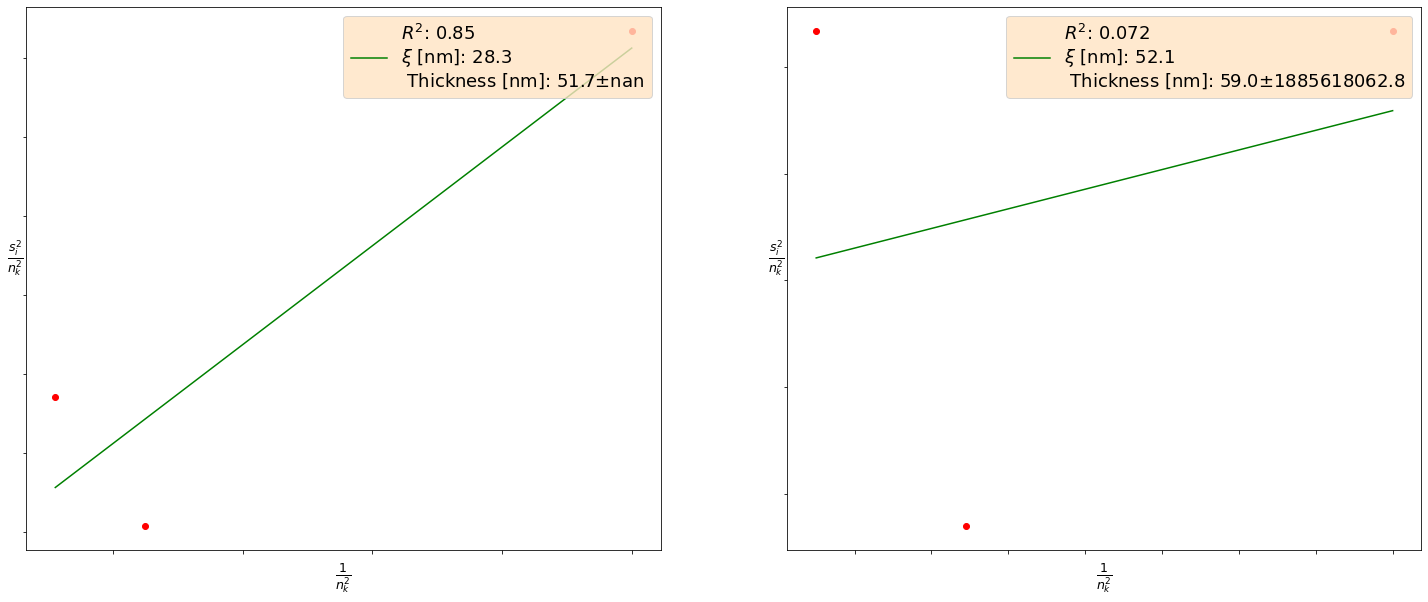

In [8]:
d_hkl= get_d_hkl(hkl=kik_band.value)
wave_l = get_wavelength(slider.value*10**3)
si_list = make_si(make_theta_list(theta1.value,theta2.value,theta3.value,theta4.value),d_kik=d_kik.value, d_hkl= d_hkl, wavelength=wave_l)
get_thickness_plot(si_list, kStart=1, kStop=kStop_slider.value)


# Plans for next version:

- Comparison with simulations
- written in "OOP"
- Material's library
- writing output